# **CASE: CANCELAMENTO EM TELECOM**

---

### Instalação de bibliotecas

In [1]:
# # Para cálculo do VIF
# install.packages("rms")
# # Para cálculo do KS e AUC
# install.packages("ROCR")

### Carregamento de bibliotecas

In [2]:
library(rms)
library(ROCR)

Loading required package: Hmisc


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units




### Leitura da base de dados

In [3]:
dados_telecom <- read.table(file = "../Dados/Cancelamento_Telecom.txt",
                            sep = "\t",
                            dec = ".",
                            header = TRUE)

### Visualização da base de dados

In [4]:
View(dados_telecom)

ID_CLIENTE,SCORE_CREDITO,GENERO,IDADE,TEMPO_RELACIONAMENTO,TIPO_PLANO,RENDA,CANCELOU
<int>,<int>,<chr>,<int>,<dbl>,<chr>,<int>,<int>
1,691,Feminino,51,7.2,Pre_Pago,9104,0
2,749,Masculino,33,6.3,Pre_Pago,7916,0
3,680,Masculino,35,6.3,Pos_Pago,7374,0
4,479,Feminino,34,4.2,Pre_Pago,11342,0
5,579,Masculino,27,4.4,Pre_Pago,5522,0
6,619,Masculino,42,5.5,Pre_Pago,4593,0
7,495,Masculino,41,6.7,Pos_Pago,5295,0
8,594,Feminino,35,5.4,Pre_Pago,12984,0
9,561,Feminino,39,8.0,Pre_Pago,7560,0


### Análise exploratória breve

In [5]:
# Medidas resumo
summary(dados_telecom)

   ID_CLIENTE    SCORE_CREDITO      GENERO              IDADE      
 Min.   :    1   Min.   :376.0   Length:10000       Min.   :18.00  
 1st Qu.: 2501   1st Qu.:543.0   Class :character   1st Qu.:32.00  
 Median : 5000   Median :597.0   Mode  :character   Median :37.00  
 Mean   : 5000   Mean   :605.5                      Mean   :38.92  
 3rd Qu.: 7500   3rd Qu.:658.0                      3rd Qu.:44.00  
 Max.   :10000   Max.   :992.0                      Max.   :92.00  
 TEMPO_RELACIONAMENTO  TIPO_PLANO            RENDA          CANCELOU     
 Min.   : 0.600       Length:10000       Min.   : 1560   Min.   :0.0000  
 1st Qu.: 4.200       Class :character   1st Qu.: 5764   1st Qu.:0.0000  
 Median : 5.700       Mode  :character   Median : 7392   Median :0.0000  
 Mean   : 6.018                          Mean   : 7684   Mean   :0.0704  
 3rd Qu.: 7.500                          3rd Qu.: 9234   3rd Qu.:0.0000  
 Max.   :20.800                          Max.   :22292   Max.   :1.0000  

In [6]:
# Tabela de frequências: gênero
table(dados_telecom$GENERO)
prop.table(table(dados_telecom$GENERO))


 Feminino Masculino 
     4543      5457 


 Feminino Masculino 
   0.4543    0.5457 

In [7]:
# Tabela de frequências: tipo de plano
table(dados_telecom$TIPO_PLANO)
prop.table(table(dados_telecom$TIPO_PLANO))


Pos_Pago Pre_Pago 
    2945     7055 


Pos_Pago Pre_Pago 
  0.2945   0.7055 

In [8]:
# Tabela de frequências: cancelamento
table(dados_telecom$CANCELOU)
prop.table(table(dados_telecom$CANCELOU))


   0    1 
9296  704 


     0      1 
0.9296 0.0704 

### Análise bivariada: variável resposta vs. variáveis explicativas

In [9]:
# Comando auxiliar para aumentar resolução do gráfico (recomendado apenas no Colab)
reset_options <- options()
options(repr.plot.width = 20, repr.plot.height = 7)

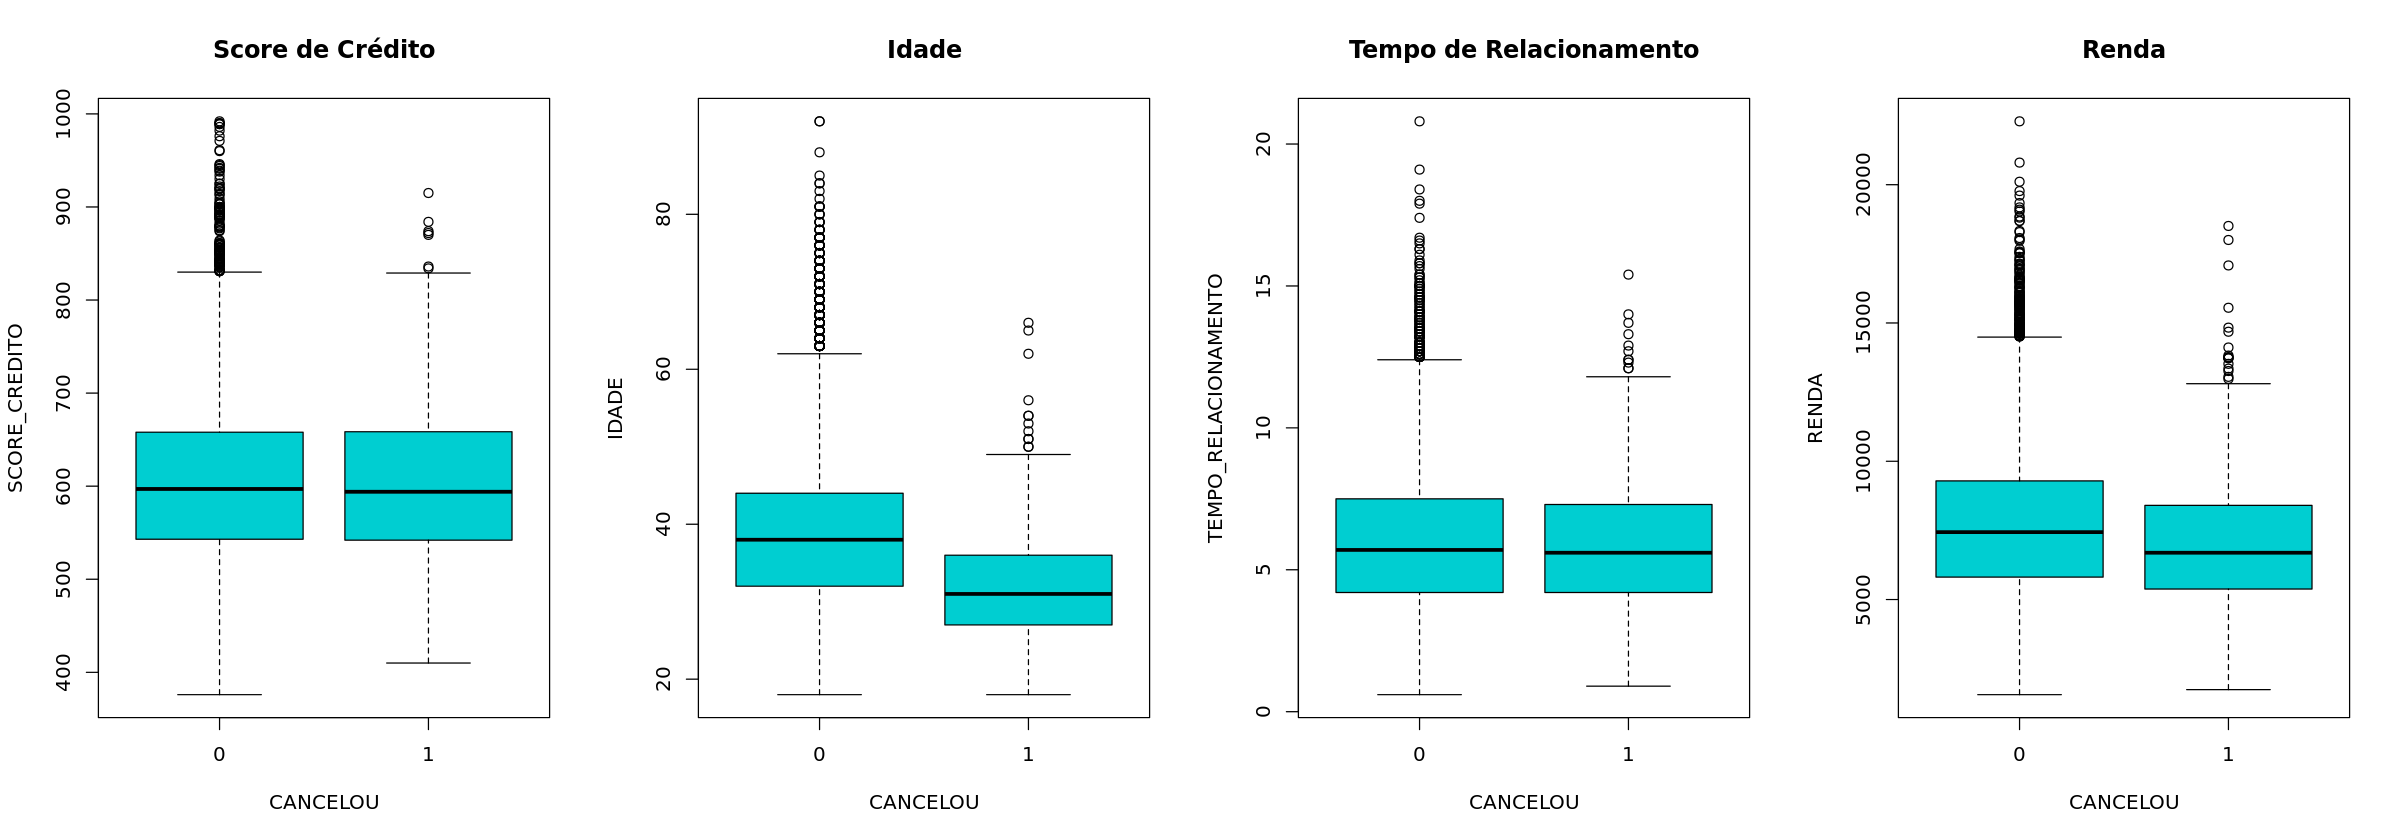

In [10]:
# Gráficos de boxplots
par(mfrow = c(1,4), cex = 1)
boxplot(SCORE_CREDITO        ~ CANCELOU, data = dados_telecom, col = "darkturquoise", main = "Score de Crédito")
boxplot(IDADE                ~ CANCELOU, data = dados_telecom, col = "darkturquoise", main = "Idade")
boxplot(TEMPO_RELACIONAMENTO ~ CANCELOU, data = dados_telecom, col = "darkturquoise", main = "Tempo de Relacionamento")
boxplot(RENDA                ~ CANCELOU, data = dados_telecom, col = "darkturquoise", main = "Renda")

In [11]:
# Resetando parâmetros gráficos (recomendado apenas no Colab)
options(reset_options)

In [12]:
# Tabela de frequências: gênero versus resposta (somando 100% nas linhas)
table(dados_telecom$GENERO, dados_telecom$CANCELOU)
prop.table(table(dados_telecom$GENERO, dados_telecom$CANCELOU), 1)

           
               0    1
  Feminino  4225  318
  Masculino 5071  386

           
                     0          1
  Feminino  0.93000220 0.06999780
  Masculino 0.92926516 0.07073484

In [13]:
# Tabela de frequências: tipo de plano versus resposta (somando 100% nas linhas)
table(dados_telecom$TIPO_PLANO, dados_telecom$CANCELOU)
prop.table(table(dados_telecom$TIPO_PLANO, dados_telecom$CANCELOU), 1)

          
              0    1
  Pos_Pago 2896   49
  Pre_Pago 6400  655

          
                    0          1
  Pos_Pago 0.98336163 0.01663837
  Pre_Pago 0.90715804 0.09284196

### Modelo de regressão logística múltipla

In [14]:
# Comando auxiliar para para omitir notação científica nos p-valores e controlar largura dos outputs na tela do Colab
options(scipen = 999, width = 200)

In [15]:
# Ajuste do modelo 1: inicial
regressao_1 <- glm(CANCELOU ~
                     SCORE_CREDITO +
                     GENERO +
                     IDADE +
                     TEMPO_RELACIONAMENTO +
                     TIPO_PLANO +
                     RENDA,
                   family = binomial(link = 'logit'),
                   data = dados_telecom)

summary(regressao_1)


Call:
glm(formula = CANCELOU ~ SCORE_CREDITO + GENERO + IDADE + TEMPO_RELACIONAMENTO + 
    TIPO_PLANO + RENDA, family = binomial(link = "logit"), data = dados_telecom)

Coefficients:
                        Estimate  Std. Error z value             Pr(>|z|)    
(Intercept)           0.54195649  0.40508470   1.338                0.181    
SCORE_CREDITO        -0.00003190  0.00048113  -0.066                0.947    
GENEROMasculino      -0.04805218  0.08191646  -0.587                0.557    
IDADE                -0.10524076  0.00577591 -18.221 < 0.0000000000000002 ***
TEMPO_RELACIONAMENTO -0.02258008  0.01742456  -1.296                0.195    
TIPO_PLANOPre_Pago    1.84595884  0.15142423  12.191 < 0.0000000000000002 ***
RENDA                -0.00010475  0.00001673  -6.262        0.00000000038 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5093.4  on 9999  degrees of freedom
Residual d

In [16]:
# Ajuste do modelo 2: retirando SCORE_CREDITO
regressao_2 <- glm(CANCELOU ~
                     GENERO +
                     IDADE +
                     TEMPO_RELACIONAMENTO +
                     TIPO_PLANO +
                     RENDA,
                   family = binomial(link = 'logit'),
                   data = dados_telecom)

summary(regressao_2)


Call:
glm(formula = CANCELOU ~ GENERO + IDADE + TEMPO_RELACIONAMENTO + 
    TIPO_PLANO + RENDA, family = binomial(link = "logit"), data = dados_telecom)

Coefficients:
                        Estimate  Std. Error z value             Pr(>|z|)    
(Intercept)           0.52270749  0.28251230   1.850               0.0643 .  
GENEROMasculino      -0.04804121  0.08191635  -0.586               0.5576    
IDADE                -0.10524042  0.00577587 -18.221 < 0.0000000000000002 ***
TEMPO_RELACIONAMENTO -0.02259241  0.01742332  -1.297               0.1947    
TIPO_PLANOPre_Pago    1.84597972  0.15142381  12.191 < 0.0000000000000002 ***
RENDA                -0.00010475  0.00001673  -6.262        0.00000000038 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5093.4  on 9999  degrees of freedom
Residual deviance: 4379.5  on 9994  degrees of freedom
AIC: 4391.5

Number of Fisher Scoring iterations:

In [17]:
# Ajuste do modelo 3: retirando GENERO
regressao_3 <- glm(CANCELOU ~
                     IDADE +
                     TEMPO_RELACIONAMENTO +
                     TIPO_PLANO +
                     RENDA,
                   family = binomial(link = 'logit'),
                   data = dados_telecom)

summary(regressao_3)


Call:
glm(formula = CANCELOU ~ IDADE + TEMPO_RELACIONAMENTO + TIPO_PLANO + 
    RENDA, family = binomial(link = "logit"), data = dados_telecom)

Coefficients:
                        Estimate  Std. Error z value             Pr(>|z|)    
(Intercept)           0.49443900  0.27839007   1.776               0.0757 .  
IDADE                -0.10516076  0.00577460 -18.211 < 0.0000000000000002 ***
TEMPO_RELACIONAMENTO -0.02270529  0.01742521  -1.303               0.1926    
TIPO_PLANOPre_Pago    1.84514225  0.15141110  12.186 < 0.0000000000000002 ***
RENDA                -0.00010467  0.00001673  -6.258       0.000000000389 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5093.4  on 9999  degrees of freedom
Residual deviance: 4379.8  on 9995  degrees of freedom
AIC: 4389.8

Number of Fisher Scoring iterations: 7


In [18]:
# Ajuste do modelo 4: retirando TEMPO_RELACIONAMENTO
regressao_4 <- glm(CANCELOU ~
                     IDADE +
                     TIPO_PLANO +
                     RENDA,
                   family = binomial(link = 'logit'),
                   data = dados_telecom)

summary(regressao_4)


Call:
glm(formula = CANCELOU ~ IDADE + TIPO_PLANO + RENDA, family = binomial(link = "logit"), 
    data = dados_telecom)

Coefficients:
                     Estimate Std. Error z value             Pr(>|z|)    
(Intercept)         0.3800625  0.2640484   1.439                 0.15    
IDADE              -0.1051055  0.0057732 -18.206 < 0.0000000000000002 ***
TIPO_PLANOPre_Pago  1.8430802  0.1513994  12.174 < 0.0000000000000002 ***
RENDA              -0.0001075  0.0000166  -6.477      0.0000000000938 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5093.4  on 9999  degrees of freedom
Residual deviance: 4381.5  on 9996  degrees of freedom
AIC: 4389.5

Number of Fisher Scoring iterations: 7


In [19]:
# Avaliação de colinearidade no modelo 4
data.frame(VIF = vif(regressao_4))

,VIF
,<dbl>
IDADE,1.003087
TIPO_PLANOPre_Pago,1.001811
RENDA,1.001501


### Intervalos de confiança

In [20]:
# Escolha do beta (0 para intercepto, ou 1, 2, ... para os parâmetros referentes a cada variável explicativa)
beta = 0

In [21]:
# Cálculo do intervalo
print("Limite inferior")
as.numeric(regressao_4$coefficients[beta + 1] - 1.96 * coef(summary(regressao_4))[beta + 1, "Std. Error"])
print("Limite superior")
as.numeric(regressao_4$coefficients[beta + 1] + 1.96 * coef(summary(regressao_4))[beta + 1, "Std. Error"])

[1] "Limite inferior"


[1] -0.1374724

[1] "Limite superior"


[1] 0.8975974

### Aplicação do modelo e definição de resposta predita

In [22]:
# Aplicação do modelo na base (criação de uma nova coluna chamada "probabilidade")
dados_telecom$probabilidade <- predict(regressao_4,
                                       dados_telecom,
                                       type = "response")

In [23]:
# Definição de ponto de corte (padrão: % de 1's na amostra)
ponto_corte <- mean(dados_telecom$CANCELOU)
ponto_corte

[1] 0.0704

In [24]:
# Definição da resposta predita pelo modelo (criação de uma nova coluna chamada "predito")
dados_telecom$predito <- as.factor(ifelse(dados_telecom$probabilidade > ponto_corte, 1, 0))

### Análise de desempenho

In [25]:
# Tabela de classificação
tabela <- table(dados_telecom$CANCELOU, dados_telecom$predito)

In [26]:
# Acurácia
(tabela[1,1] + tabela[2,2]) / sum(tabela)

[1] 0.6586

In [27]:
# Especificidade
tabela[1,1] / (tabela[1,1] + tabela[1,2])

[1] 0.6512478

In [28]:
# Sensibilidade
tabela[2,2] / (tabela[2,1] + tabela[2,2])

[1] 0.7556818

In [29]:
# KS
pred <- prediction(dados_telecom$probabilidade, dados_telecom$CANCELOU)
perf <- performance(pred, "tpr", "fpr")
ks <- max(attr(perf, 'y.values')[[1]] - attr(perf, 'x.values')[[1]])

print(ks)

[1] 0.4140808


In [30]:
# AUC
pred <- prediction(dados_telecom$probabilidade, dados_telecom$CANCELOU)
auc <- performance(pred, "auc")
auc <- auc@y.values[[1]]

print(auc)

[1] 0.782512


### Exemplo de uso (aplicação) do modelo

In [31]:
# Criação de base de dados com um novo cliente, que possui plano pré-pago, renda mensal de 5.000 reais e 30 anos de idade.
# Obs.: os nomes das colunas e padrão de conteúdo devem ser idênticos aos da base utilizada para construção do modelo
novos_dados <- data.frame(IDADE      = c(30),
                          TIPO_PLANO = c("Pre_Pago"),
                          RENDA      = c(5000))

In [32]:
# Aplicação do modelo
novos_dados$PROB_CANCELAR_6M <- predict(regressao_4, novos_dados, type = "response")
View(novos_dados)

IDADE,TIPO_PLANO,RENDA,PROB_CANCELAR_6M
<dbl>,<chr>,<dbl>,<dbl>
30,Pre_Pago,5000,0.1873068
